# Assignment 8: Classification with SVMs

# Total: 20 Marks 
## Instructions

* Complete the assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline

TODO:
* Write accuracy, specificty, etc in Q3


In [31]:
#You will need to load your libraries
# You may need these
import matplotlib.pyplot as plt 
import seaborn as sb
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix,balanced_accuracy_score
import sklearn.svm as svm
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

## Part A: 2 Mark

Read in the `emails.txt` dataset. Remove the `time`, `winner` and `number` columns.

In [32]:
df = pd.read_csv("email.txt",delimiter="\t")

model_data = df.drop(['time','winner', 'number'], axis = 'columns')
model_data.head()


,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess
0,0,0,1,0,0,0,0,0,0,0,0,11.370,202,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,10.504,202,1,0,0,0,1
2,0,0,1,0,0,0,0,4,1,0,0,7.773,192,1,0,0,0,6
3,0,0,1,0,0,0,0,0,0,0,0,13.256,255,1,0,0,0,48
4,0,0,1,0,0,0,0,0,0,0,2,1.231,29,0,0,0,0,1


## Part B: 2 Mark

Split the data into train and test.  Hold out 50% of observations as the test set.  Pass `random_state=0` to `train_test_split` to ensure you get the same train and tests sets as the solution.

In [33]:
X = model_data.drop('spam', axis='columns')
y = model_data.spam

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size=0.5, 
                                                random_state=0)

## Part C: 1 Mark

Create a pipeline for your support vector machine.  You can start with a `kernel="rbf"` and `gamma="auto"`.  Scale your inputs before passing them to your model by including a `StandardScaler`.

In [34]:
model_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('svm', svm.SVC(kernel="rbf", gamma="auto"))
])

## Part D: 3 Marks

Use your model to construct a confusion matrix by fitting and predicting on the training data (I've inlcluded a little helper function to make looking at the confusion matrix a little easier). Then answer the following using the confusion matrix (don't use sklearn's functions):

* What is your model's training accuracy?
* What is your model's training precision?
* What is your model's training recall?

Confusion matrix, without normalization


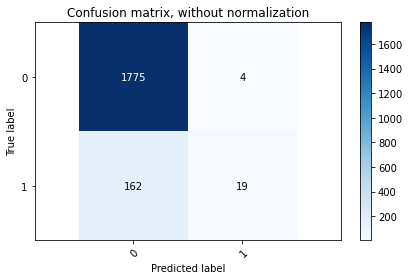

In [35]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax

S = model_pipeline.fit(Xtrain, ytrain)
y_pred = S.predict(Xtrain)
plot_confusion_matrix(ytrain, y_pred,S.classes_)


# Part E: 4 Marks

Imagine you are designing a model to filter out spam.  

* Would you want your model to have a high a high sensitivity?  Why or why not?  Answer in no more than 3 sentences.

* Would you wanr your model to have a low specificity? Why or why not? Answer in no more than 3 sentences

---
* Ideally, we would want both igh specificity and sensitivity. But since it is a larger pain to filter out important emails for the users than let a few spam emails make it to their inbox I would sa that having a high sensitivity is more important in this case than high specificity.


## Part E:  1 Mark

Estimate your support vector machine's out of sample sensitivity by using 5 fold cross validation.

In [40]:

def specificity_score(y,yhat):
    TN = np.logical_and(y==0,yhat==0).sum()
    FP = np.logical_and(y==0,yhat==1).sum()
    return TN/(TN+FP)

def sensitivity_score(y,yhat):
    TP = np.logical_and(y==1,yhat==1).sum()
    FN = np.logical_and(y==1,yhat==0).sum()
    return TP/(TP+FN)

cv_score = cross_val_score(model_pipeline, Xtrain, ytrain, cv=5, scoring=make_scorer(sensitivity_score))

cv_score_mean = cv_score.mean()

print(cv_score_mean)

0.05555555555555556


## Part F: 4 Marks

Read the documentation for `GridSearchCV` in order to learn how to montior multiple metrics during grid search cross validation.  Once you have learned how to keep track of multiple scores, implement a grid search for your pipeline which monitors sensitivity and specificity. You will need to tell `GridsearchCV` which to prefer when it does the model selection (see the `refit` argument in the documentation). Note, sklearn does not have a `specificity_score` so you need to write your own function to do so. Search over your pipeline's kernel and gamma using `kernel = ['rbf','sigmoid']` and `gamma = np.linspace(1e-5, 5)`.

In [ ]:
kernel = ['rbf','sigmoid']
gamma = np.linspace(1e-5, 5)
param_grid = {'svm__gamma': gamma,
             'svm__kernel': kernel}
scoring={'spec':make_scorer(specificity_score),
        'sens':make_scorer(sensitivity_score)}

gscv = GridSearchCV(model_pipeline, param_grid=param_grid, cv = 5,scoring=scoring,refit='sens')

gscv.fit(Xtrain, ytrain)
res = pd.DataFrame(gscv.cv_results_)
#sb.lineplot(data=res,x='param_C',y='mean_test_sens')


## Part G: 1 Mark

What was the cross validated sensitivity for your regularized model?


In [51]:
gscv.best_score_

0.2160660660660661

## Part H: 1 Mark

Plot how the mean test sensitivity and specificity changes as `gamma` changes.  Color the lines according to `kernel`.

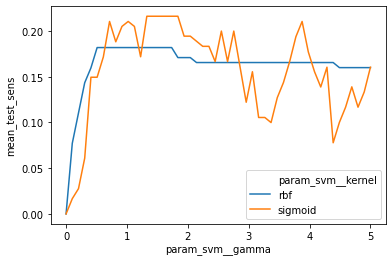

In [52]:

sb.lineplot(data=res,x='param_svm__gamma',y='mean_test_sens',hue='param_svm__kernel')

# Part I: 1 Mark

Use your selected model to predict on the test set.  Compute the test sensitivity and specificity.  Interpret the sensitivity and specificity in terms of the conditional probabilities.
